In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import IPython

In [42]:
def acf(data):
    x = np.array(data) 

    # Mean
    mean = np.mean(data)

    # Variance
    var = np.var(data)

    # Normalized data
    ndata = data - mean

    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr

# Problem 1

D:\Applications\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


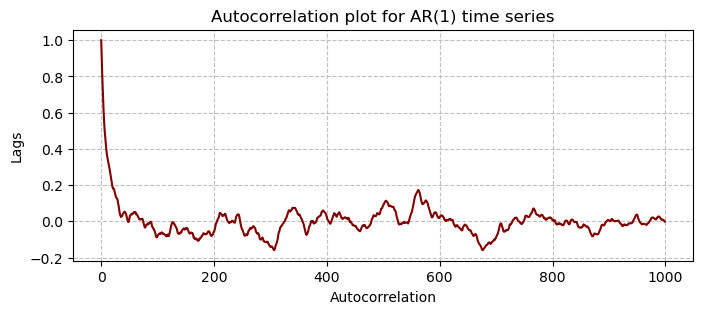

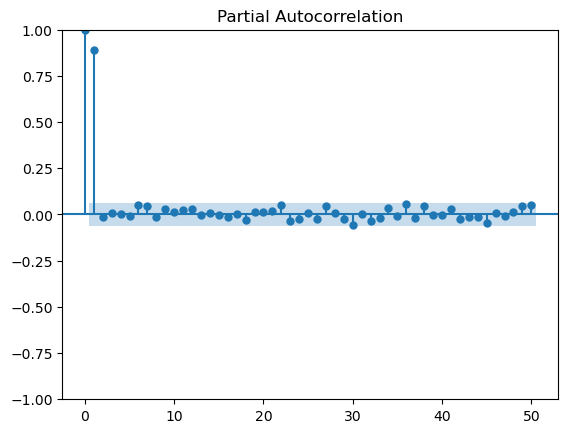

In [43]:
#AR1 
def create_series(n, phi0, phi1):
    time_series = [phi0]
    mean_reversion = phi0 / (1-phi1);
    mu, sigma = 0, (mean_reversion * 0.05)
    residuals = np.random.normal(mu, sigma, n)
    for i in range(n-1):
        time_series.append(phi0 + phi1 * time_series[i] + residuals[i])
    return time_series

phi1 = 0.9
phi0 = 0.02
time_series = create_series(1000, phi0, phi1)

plt.figure(figsize = (8,3))
plt.grid(linestyle="--", color="silver")
plt.title("Autocorrelation plot for AR(1) time series")
plt.xlabel("Autocorrelation")
plt.ylabel("Lags")

plt.plot(acf(time_series), color="maroon")
plot_pacf(time_series, lags=50);

The process is covariance stationary because
- It has a finite mean, its not increasing or decreasing
- It has a finite variance, its volatility is not increasing or decreasing
- It has a finite covariance, as visible from the partial acf plot there is no dependence of the variable apart from 1st lag

The time series AR(1) model can be represented by the following expressions

$ x_{t} = \sum_{j=0}^{t-1}{\phi_{1}^j}{\epsilon_{t-j}} $

$ \frac{\partial{x_t}}{\partial{\epsilon_{t-j}}} = \phi_1^j $

In [44]:
print("Dynamic multiplier for 6 periods ago: \f" , (phi1 ** 6))

Dynamic multiplier for 6 periods ago:  0.531441


In [45]:
mu = phi0 / (1-phi1); #mean reversion
r_t = -0.01

# calculate E(X(t))
x_t = r_t - mu

# calculate E(X(t+4))
for i in range(4):
    x_tplus1 = phi1*x_t
    x_t = x_tplus1
    
# calculate E(R(t+4))    
r_t = x_t + mu
print("Expected value of R at t+4 = ", r_t)

Expected value of R at t+4 =  0.06221899999999997


# Problem 2

In [46]:
df = pd.read_excel("PPIFGS.xls", parse_dates=['DATE'], index_col="DATE")
df.rename({'VALUE': 'PPI'}, axis=1, inplace=True)
df['ChangePPI'] = df["PPI"] - df["PPI"].shift(1)
df['Log(PPI)'] = np.log(1+df["PPI"])
df['ChangeLog(PPI)'] = df['Log(PPI)'] - df['Log(PPI)'].shift(1)
df = df.dropna()
df

,PPI,ChangePPI,Log(PPI),ChangeLog(PPI)
DATE,,,,
1947-07-01,26.7,0.5,3.321432,0.018215
1947-10-01,27.7,1.0,3.356897,0.035465
1948-01-01,28.0,0.3,3.367296,0.010399
1948-04-01,28.6,0.6,3.387774,0.020479
1948-07-01,28.8,0.2,3.394508,0.006734
...,...,...,...,...
2014-07-01,201.3,-0.6,5.309752,-0.002962
2014-10-01,196.7,-4.6,5.286751,-0.023001
2015-01-01,193.3,-3.4,5.269403,-0.017347


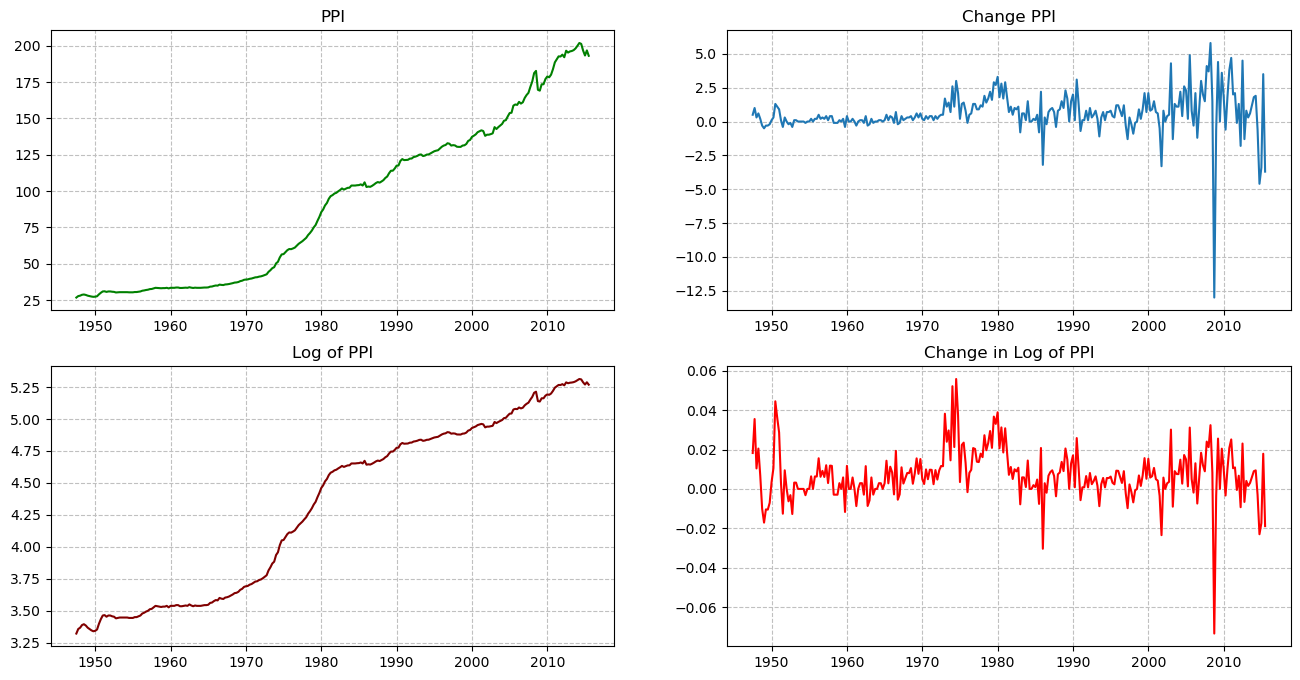

In [47]:
plt.figure(figsize=(16, 8)) 
plt.subplot(2,2,1)
plt.grid(linestyle="--", color="silver")
plt.title("PPI")
plt.plot(df.index, df["PPI"], color="green")

plt.subplot(2,2,2)
plt.grid(linestyle="--", color="silver")
plt.title("Change PPI")
plt.plot(df.index, df["ChangePPI"])

plt.subplot(2,2,3)
plt.grid(linestyle="--", color="silver")
plt.title("Log of PPI")
plt.plot(df.index, df["Log(PPI)"], color="maroon")

plt.subplot(2,2,4)
plt.grid(linestyle="--", color="silver")
plt.title("Change in Log of PPI")
plt.plot(df.index, df["ChangeLog(PPI)"], color="red")

- PPI and Log of PPI look like they have positive autocorrelation which implies they most likely have a non-finite mean so they will not be covariance stationary
- Change in PPI looks like it has a non finite variance as the volatility seems to increase as time goes by
- Change in Log of PPI seems to have a finite variance and mean so it could be covariance stationary

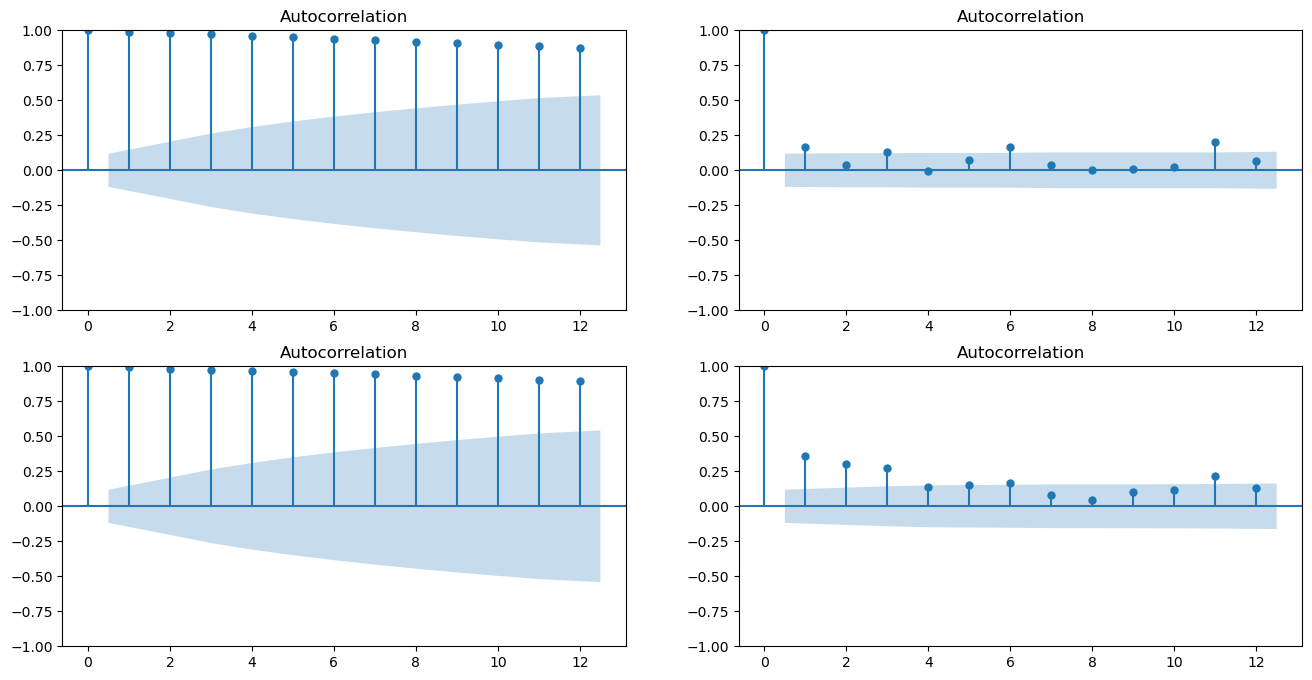

In [48]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
plot_acf(df["PPI"].squeeze(), label="PPI", lags=12, ax=ax[0][0]);
plot_acf(df["ChangePPI"].squeeze(), label="Change in PPI", lags=12, ax=ax[0][1]);
plot_acf(df["Log(PPI)"].squeeze(), label="Log of PPI", lags=12, ax=ax[1][0]);
plot_acf(df["ChangeLog(PPI)"].squeeze(), label="Change in Log of PPI", lags=12, ax=ax[1][1]);

There is a clear positive autocorrelation in the time series as seen from the PPI and log PPI plots. To have a definite mean reversion level for our time series we need to model ensuring the autocorrelation lies under values acceptable within 95% confidence interval. Lets look at the pacf for log and change in log series to generate enough information about independent autocorrelation so as to detect if the AR(1) model is a good fit. 

D:\Applications\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


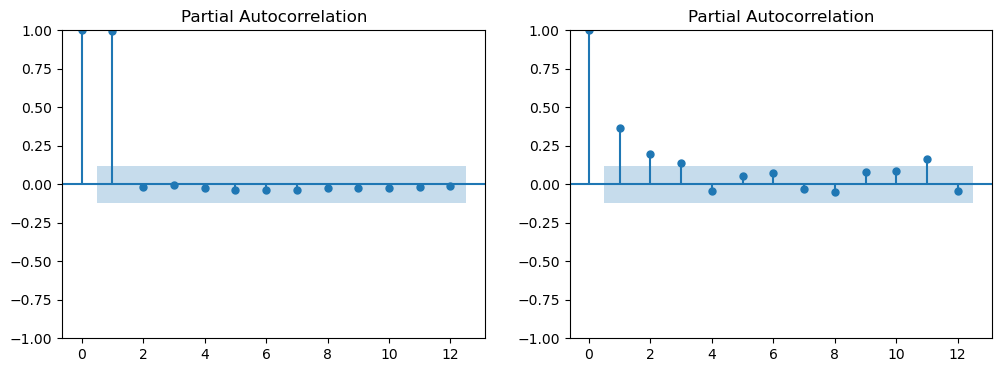

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_pacf(df["Log(PPI)"].squeeze(), label="Log of PPI", lags=12, ax=ax[0]);
plot_pacf(df["ChangeLog(PPI)"].squeeze(), label="Change in Log of PPI", lags=12, ax=ax[1]);

Clearly evident from pacf plots that Log of PPI has no independent significant autocorrelation after the first lag. AR(1) model for this series would be a good fit

In [50]:
model = AutoReg(df["Log(PPI)"], 1)
reg = model.fit(cov_type="HC0")
reg.summary()

D:\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Log(PPI)   No. Observations:                  273
Model:                     AutoReg(1)   Log Likelihood                 798.101
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sat, 28 Jan 2023   AIC                          -1590.202
Time:                        17:36:13   BIC                          -1579.385
Sample:                    10-01-1947   HQIC                         -1585.859
                         - 07-01-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0094      0.005      1.816      0.069      -0.001       0.019
Log(PPI).L1     0.9995      0.001    829.687      0.000       0.997       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           +0.0000j            1.0005            0.0000
-----------------------------------------------------------------------------
"""

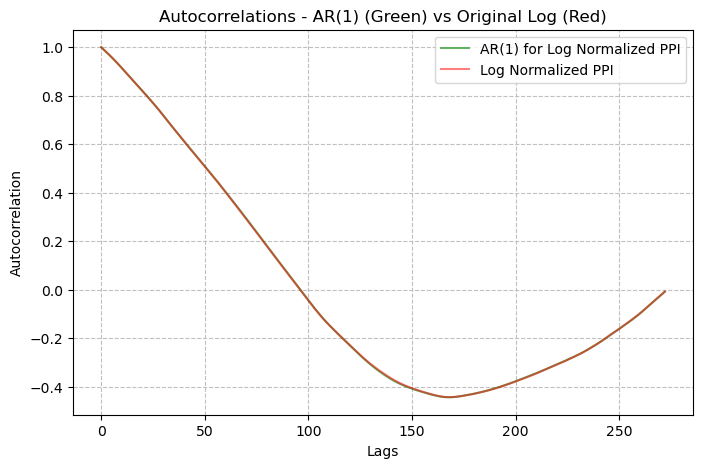

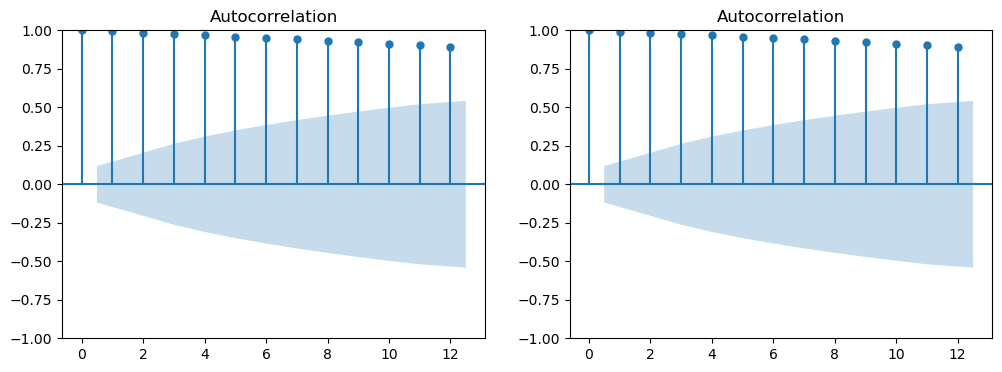

In [51]:
df["AR(1)"] = reg.predict()
df["AR(1)"].iloc[0] = df["Log(PPI)"].iloc[0]

# Plotting both the curves simultaneously
plt.figure(figsize=(8,5))
plt.grid(linestyle="--", color="silver")
plt.plot(range(0, 273), acf(df["AR(1)"]), color='g', alpha=0.6, label='AR(1) for Log Normalized PPI')
plt.plot(range(0, 273), acf(df["Log(PPI)"]), color='r', alpha=0.5, label='Log Normalized PPI')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelations - AR(1) (Green) vs Original Log (Red)")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(df["Log(PPI)"].squeeze(), label="Log of PPI", lags=12, ax=ax[0]);
plot_acf(df["AR(1)"].squeeze(), label="AR(1)", lags=12, ax=ax[1]);

We can see high precision in matching autocorrelations of the log(PPI) series and its AR(1) counterpart

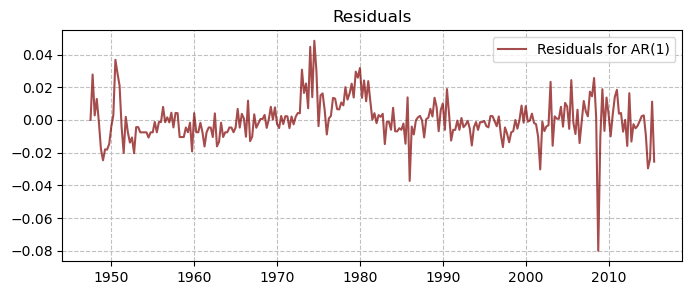

In [125]:
residuals = (df["Log(PPI)"] - df["AR(1)"])
plt.figure(figsize=(8,3))
plt.grid(linestyle="--", color="silver")
plt.title("Residuals")
plt.plot(df.index, residuals, color='maroon', alpha=0.7, label='Residuals for AR(1)')
plt.legend()

In [126]:
sm.stats.acorr_ljungbox(reg.resid, lags=[8,12], return_df=True)

,lb_stat,lb_pvalue
8,103.743060,7.319253e-19
12,128.163442,1.441560e-21


The p-values of the l_jung test are extremely small hence the residuals are not significantly independent

Authors
- Ringe Akash Mukul
- Atreyapurarpu Lalitha
- Chang Wan-Hsin
- Chen Zhuo
- Jiang Tianchen